# Intro to DLC2Action (mini)

DLC2Action is a package for automatic behavior prediction. It offers implementation of SOTA models and keeps track of experiments.

To see how it works, we will experiment on a relatively small [publically available](https://github.com/ETHZ-INS/DLCAnalyzer/tree/master/data/OFT) dataset (Sturman, 2020). Run the code below to download the data.

This is a minimalistic version of this notebook, check out demo_notebook.ipynb for more information.

In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1BhAAy_YYxWXYVSpCmYXIAOEV9waoMwcK
!apt-get install unzip
!unzip OFT.zip -d OFT

Downloading...
From: https://drive.google.com/uc?id=1BhAAy_YYxWXYVSpCmYXIAOEV9waoMwcK
To: /home/liza/DLC2Action_minimal/examples/OFT.zip
100%|█████████████████████████████████████████| 475M/475M [00:04<00:00, 111MB/s]
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Archive:  OFT.zip
   creating: OFT/OFT/
  inflating: OFT/__MACOSX/._OFT      
  inflating: OFT/OFT/.DS_Store       
  inflating: OFT/__MACOSX/OFT/._.DS_Store  
   creating: OFT/OFT/Labels/
   creating: OFT/OFT/Output_DLC/
  inflating: OFT/OFT/Labels/23_02_A_190507135734.csv  
  inflating: OFT/OFT/Labels/12_01_A_190507144429.csv  
  inflating: OFT/OFT/Labels/53_04_A_190507135800.csv  
  inflating: OFT/OFT/Labels/43_03_A_190507151557.csv  
  inflating: OFT/OFT/Labels/57_04_A_190507150030.csv  
  inflating: OFT/OFT/Labels/25_02_A_190507142904.csv  
  inflating: OFT/OFT/Labels/AllLabDataOFT_final.csv  


... installation

for now:
```
git clone https://github.com/AlexEMG/DLC2Action
cd DLC2Action
conda create --name DLC2Action python=3.9
conda activate DLC2Action
python -m pip install .
```

In [13]:
from dlc2action.project import Project
import os

CURRENT_PATH = os.getcwd()
DATA_PATH = os.path.join(CURRENT_PATH, "OFT", "OFT", "Output_DLC")
LABELS_PATH = os.path.join(CURRENT_PATH, "OFT", "OFT", "Labels")
PROJECTS_PATH = os.path.join(CURRENT_PATH, "DLC2Action")

High-level methods in DLC2Action are almost exclusively accessed through the `dlc2action.project.Project` class. A project instance should loosely correspond to a specific goal (e.g. generating automatic annotations for dataset A with input format X). You can use it to optimize hyperparameters, run experiments, analyze results and generate new data.

**Best practices**
- When you need to do something with a different data type or unrelated files, it's better to create a new project to keep the experiment history easy to understand.
- Each project is associated with a folder on your computer that contains all settings, meta files and experiment outputs. Those folders are created in the folder at `projects_path`. It's generally a good idea to choose one and stick to it throughout projects.

### Creating a project

Let's begin!

We will create a project called `"rat_simba"`, with input and annotation data in `"simba"` format. 

You can run `Project.print_data_types()` and `Project.print_annotation_types()` to find out more about other options.

In [18]:
# Project.remove_project("oft", projects_path=PROJECTS_PATH)
project = Project(
    "oft",
    data_path=DATA_PATH,
    annotation_path=LABELS_PATH,
    projects_path=PROJECTS_PATH,
    data_type="dlc_track",
    annotation_type="csv",
)

## Setting parameters

After the project is created, it's time to configure the parameter settings. 

The first step is to check which essential parameters are missing with `project.list_blanks()`.

In [22]:
project.list_blanks()

Before running experiments, please update all the blanks.
To do that, you can run this.
--------------------------------------------------------
project.update_parameters(
    {
        "data": {
            "data_suffix": ..., # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "canvas_shape": ..., # list; the size of the canvas where the pose was defined
            "annotation_suffix": ..., # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
        },
        "general": {
            "exclusive": ..., # bool; if true, single-label classification is used; otherwise multi-label
        },
    }
)
--------------------------------------------------------
Replace ... with relevant values.


We can copy this code, fill in the blanks and run it. 

We will also set the number of epochs here. Normally the default should be fine but for the purpose of this tutorial we want to set it smaller so that our experiments can finish in time.

In [23]:
project.update_parameters(
    {
        "data": {
            "data_suffix": "DeepCut_resnet50_Blockcourse1May9shuffle1_1030000.h5", # set; the data files should have the format of {video_id}{data_suffix}, e.g. video1_suffix.pickle, where video1 is the video is and _suffix.pickle is the suffix
            "canvas_shape": [928, 576], # list; the size of the canvas where the pose was defined
            "annotation_suffix": ".csv", # str | set, optional the suffix or the set of suffices such that the annotation files are named {video_id}{annotation_suffix}, e.g, video1_suffix.pickle where video1 is the video id and _suffix.pickle is the suffix
        },
        "general": {
            "exclusive": True, # bool; if true, single-label classification is used; otherwise multi-label
        },
        "training": {
            "num_epochs": 15,
        }
    }
)

Now we're all set and can start training models.

We will now choose the architectures we want to try out. If you want to see other options, check `project.help("models")`.

In [27]:
MODEL_NAME1 = "c2f_tcn"
MODEL_NAME2 = "transformer"

All done! Now we're ready to run experiments. 

## Hyperparameter search

There are many hyperparameters in model training, like the number of layers in a model or loss coefficients. The default settings for those parameters should generate reasonable results on most datasets but in order to get the most out of our data we can run a hyperparameter search.

The easiest way to find a good set of hyperparameters for your data is to run `project.run_default_hyperparameter_search()` with your morel of choice.

In [29]:
for model in [MODEL_NAME1, MODEL_NAME2]:
    project.run_default_hyperparameter_search(
        f"{model}_search",
        model_name=model,
        metric="f1",
        num_epochs=10,
        n_trials=5,
    )


[I 2022-11-17 00:21:10,686] A new study created in memory with name: no-name-bd3a5adf-269b-456d-9343-8f5afb811239


SEARCH c2f_tcn_search
Computing input features...


 15%|█▌        | 3/20 [00:03<00:19,  1.16s/it]
[W 2022-11-17 00:21:14,369] Trial 0 failed because of the following error: KeyError('Requested level (scorer) does not match index name (None)')
multiprocess.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/liza/miniconda3/envs/DLC2Action/lib/python3.9/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/liza/miniconda3/envs/DLC2Action/lib/python3.9/site-packages/pathos/helpers/mp_helper.py", line 15, in <lambda>
    func = lambda args: f(*args)
  File "/home/liza/DLC2Action_minimal/dlc2action/data/input_store.py", line 1127, in make_data_dictionary
    data_new, tag = self._open_data(filename, self.default_agent_name)
  File "/home/liza/DLC2Action_minimal/dlc2action/data/input_store.py", line 1514, in _open_data
    temp = temp.droplevel("scorer", axis=1)
  File "/home/liza/miniconda3/envs/DLC2Action/lib/python3.9/site-packages/pandas/core/generic.py", l

KeyError: 'Requested level (scorer) does not match index name (None)'

## Training models

Now we can train models with the best hyperparameters.

In [19]:
for model in [MODEL_NAME1, MODEL_NAME2]:
    project.run_episode(
        f"{model}_best",
        load_search=f"{model}_search", # loading the search
        force=True, # when force=True, if an episode with this name already exists it will be overwritten -> use with caution!
        parameters_update={
            "general": {"model_name": model} # note that you do need to set the model explicitly, it is not loaded with the search
        },
    )

TRAINING c2f_tcn_best::0
Computing input features...


100%|██████████| 12/12 [00:24<00:00,  2.06s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Number of samples:
    validation:
      {0: 10660, 1: 5414, 2: 1340, 3: 1816, 4: 500, 5: 2594, 6: 0, 7: 0}
    training:
      {0: 27747, 1: 16566, 2: 87393, 3: 10991, 4: 23594, 5: 45042, 6: 92, 7: 61104}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 415/415 [00:01<00:00, 261.54it/s]


Initializing class weights:
     0: 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.015, 0.025, 0.005, 0.038, 0.018, 0.009, 4.511, 0.007
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0003, f1 0.264, precision 0.182
validation: loss 0.0005, f1 0.054, precision 0.069
[epoch 2]: loss 0.0002, f1 0.380, precision 0.294
validation: loss 0.0012, f1 0.064, precision 0.059
[epoch 3]: loss 0.0002, f1 0.426, precision 0.329
validation: loss 0.0018, f1 0.084, precision 0.069
[epoch 4]: loss 0.0002, f1 0.464, precision 0.366
validation: loss 0.0010, f1 0.077, precision 0.048
[epoch 5]: loss 0.0001, f1 0.509, precision 0.404
validation: loss 0.0014, f1 0.074, precision 0.043
[epoch 6]: loss 0.0001, f1 0.529, precision 0.423
validation: loss 0.0008, f1 0.076, precision 0.045
[epoch 7]: loss 0.0001, f1 0.529, precision 0.425
validation: loss 0.0004, f1 0.083, precision

100%|██████████| 415/415 [00:01<00:00, 277.67it/s]


Initializing class weights:
     0: 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.015, 0.025, 0.005, 0.038, 0.018, 0.009, 4.511, 0.007
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0004, f1 0.246, precision 0.166
validation: loss 0.0006, f1 0.065, precision 0.053
[epoch 2]: loss 0.0002, f1 0.359, precision 0.266
validation: loss 0.0010, f1 0.075, precision 0.063
[epoch 3]: loss 0.0002, f1 0.398, precision 0.294
validation: loss 0.0009, f1 0.075, precision 0.052
[epoch 4]: loss 0.0002, f1 0.465, precision 0.360
validation: loss 0.0008, f1 0.086, precision 0.055
[epoch 5]: loss 0.0001, f1 0.508, precision 0.398
validation: loss 0.0007, f1 0.107, precision 0.069
[epoch 6]: loss 0.0001, f1 0.552, precision 0.440
validation: loss 0.0009, f1 0.093, precision 0.057
[epoch 7]: loss 0.0001, f1 0.574, precision 0.459
validation: loss 0.0006, f1 0.099, precision

100%|██████████| 12/12 [00:29<00:00,  2.44s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:06<00:00,  1.76it/s]


Number of samples:
    validation:
      {0: 11136, 1: 5612, 2: 1340, 3: 1864, 4: 500, 5: 2808, 6: 0, 7: 0}
    training:
      {0: 29944, 1: 17585, 2: 88468, 3: 11668, 4: 24100, 5: 46886, 6: 92, 7: 61664}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Computing normalization statistics...


100%|██████████| 6592/6592 [00:12<00:00, 512.86it/s]


Initializing class weights:
     0: 0.019, 0.016, 0.023, 0.016, 0.017, 0.02, 0.018, 0.021 1: 0.22, 0.375, 0.075, 0.565, 0.274, 0.141, 71.652, 0.107
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


/home/liza/DLC2Action_minimal/dlc2action/project/meta.py:665: FutureWarning:

Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.



[epoch 1]: loss 0.0003, f1 0.332, precision 0.247
validation: loss 0.0004, f1 0.095, precision 0.057
[epoch 2]: loss 0.0002, f1 0.417, precision 0.326
validation: loss 0.0003, f1 0.091, precision 0.053
[epoch 3]: loss 0.0002, f1 0.458, precision 0.361
validation: loss 0.0004, f1 0.096, precision 0.057
[epoch 4]: loss 0.0002, f1 0.433, precision 0.335
validation: loss 0.0005, f1 0.072, precision 0.041
[epoch 5]: loss 0.0002, f1 0.439, precision 0.340
validation: loss 0.0004, f1 0.088, precision 0.053
[epoch 6]: loss 0.0001, f1 0.487, precision 0.384
validation: loss 0.0007, f1 0.090, precision 0.055
[epoch 7]: loss 0.0001, f1 0.517, precision 0.410
validation: loss 0.0005, f1 0.088, precision 0.052
[epoch 8]: loss 0.0001, f1 0.545, precision 0.442
validation: loss 0.0006, f1 0.094, precision 0.057
[epoch 9]: loss 0.0001, f1 0.555, precision 0.449
validation: loss 0.0007, f1 0.079, precision 0.047
[epoch 10]: loss 0.0001, f1 0.578, precision 0.472
validation: loss 0.0006, f1 0.087, preci

100%|██████████| 6592/6592 [00:12<00:00, 507.76it/s]


Initializing class weights:
     0: 0.019, 0.016, 0.023, 0.016, 0.017, 0.02, 0.018, 0.021 1: 0.22, 0.375, 0.075, 0.565, 0.274, 0.141, 71.652, 0.107
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission
[epoch 1]: loss 0.0003, f1 0.352, precision 0.261
validation: loss 0.0005, f1 0.046, precision 0.038
[epoch 2]: loss 0.0002, f1 0.395, precision 0.301
validation: loss 0.0004, f1 0.101, precision 0.057
[epoch 3]: loss 0.0001, f1 0.453, precision 0.354
validation: loss 0.0006, f1 0.113, precision 0.065
[epoch 4]: loss 0.0001, f1 0.472, precision 0.371
validation: loss 0.0007, f1 0.072, precision 0.044
[epoch 5]: loss 0.0001, f1 0.481, precision 0.379
validation: loss 0.0005, f1 0.094, precision 0.056
[epoch 6]: loss 0.0001, f1 0.547, precision 0.445
validation: loss 0.0006, f1 0.092, precision 0.055
[epoch 7]: loss 0.0001, f1 0.579, precision 0.475
validation: loss 0.0008, f1 0.092, precision 

## Evaluation

Now that we've trained our best models, we can analyze the results.

In [5]:
best_episodes = [f"{model}_best" for model in [MODEL_NAME1, MODEL_NAME2]]

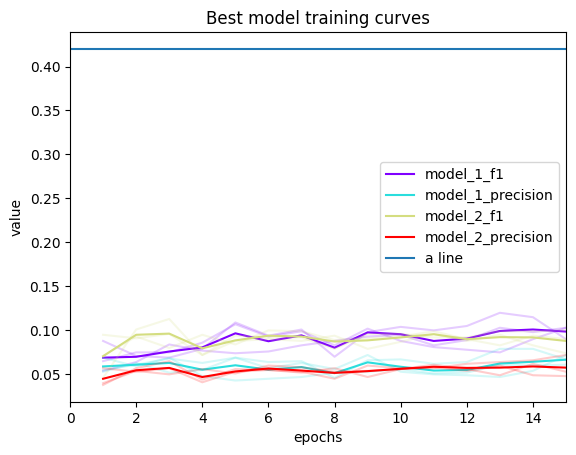

In [21]:
project.plot_episodes(
    best_episodes,
    metrics=["f1"], # F1 score
    episode_labels=["model_1", "model_2"], 
    title="Best model training curves"
)

We can also check out more metrics now. See `project.help("metrics")` to see other options.

In [8]:
for episode in best_episodes:
    project.evaluate(
        [episode],
        parameters_update={
            "general": {"metric_functions": ["segmental_f1", "mAP", "pr-auc", "f1"]},
            "metrics": {
                "f1": {"average": "none"}
            }
        }
    )

EVALUATION c2f_tcn_best
episode c2f_tcn_best::0
Computing input features...


100%|██████████| 12/12 [00:25<00:00,  2.16s/it]


Computing annotation arrays...


100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Number of samples:
    validation:
      {0: 10660, 1: 5414, 2: 1340, 3: 1816, 4: 500, 5: 2594, 6: 0, 7: 0}
    training:
      {0: 27747, 1: 16566, 2: 87393, 3: 10991, 4: 23594, 5: 45042, 6: 92, 7: 61104}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Setting loaded normalization statistics...
Initializing class weights:
     0: 0.001, 0.001, 0.002, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.015, 0.025, 0.005, 0.038, 0.018, 0.009, 4.511, 0.007
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


100%|██████████| 2/2 [00:05<00:00,  2.83s/it]


f1_0 0.158, f1_1 0.183, f1_2 0.064, f1_3 0.190, f1_4 0.113, f1_5 0.115, f1_6 0.000, f1_7 0.000, mAP 0.041, pr-auc 0.063, segmental_f1 0.093


AGGREGATED:
f1_0 0.158, f1_1 0.183, f1_2 0.064, f1_3 0.190, f1_4 0.113, f1_5 0.115, f1_6 0.000, f1_7 0.000, mAP 0.041, pr-auc 0.063, segmental_f1 0.093
Inference time: 0:00:05


EVALUATION transformer_best
episode transformer_best::0
Number of samples:
    validation:
      {0: 11136, 1: 5612, 2: 1340, 3: 1864, 4: 500, 5: 2808, 6: 0, 7: 0}
    training:
      {0: 29944, 1: 17585, 2: 88468, 3: 11668, 4: 24100, 5: 46886, 6: 92, 7: 61664}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Setting loaded normalization statistics...
Initializing class weights:
     0: 0.019, 0.016, 0.023, 0.016, 0.017, 0.02, 0.018, 0.021 1: 0.22, 0.375, 0.075, 0.565, 0.274, 0.141, 71.652, 0.107
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


100%|██████████| 31/31 [00:07<00:00,  4.25it/s]


f1_0 0.252, f1_1 0.131, f1_2 0.035, f1_3 0.101, f1_4 0.030, f1_5 0.040, f1_6 0.000, f1_7 0.000, mAP 0.018, pr-auc 0.041, segmental_f1 0.038


AGGREGATED:
f1_0 0.252, f1_1 0.131, f1_2 0.035, f1_3 0.101, f1_4 0.030, f1_5 0.040, f1_6 0.000, f1_7 0.000, mAP 0.018, pr-auc 0.041, segmental_f1 0.038
Inference time: 0:00:07




## Using trained models

When you find that you are happy with the results, you can use the model to generate predictions for new data. 

Predictions here are probabilities of each behavior being seen in each frame while suggestions are suggested intervals generated from those probabilities.

Let's generate a prediction with one of our models and look at one of the resulting files. Note that you can use multiple models and average over their predictions.

In [11]:
project.run_prediction(
    f"{MODEL_NAME1}_best_prediction",
    episode_names=[f"{MODEL_NAME1}_best"],
    force=True
)

PREDICTION c2f_tcn_best_prediction
episode c2f_tcn_best_lr1e-5::0
Number of samples:
    validation:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
    training:
      {0: 38407, 1: 21980, 2: 88733, 3: 12807, 4: 24094, 5: 47636, 6: 92, 7: 61104}
    test:
      {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
Setting loaded normalization statistics...
Initializing class weights:
     0: 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001 1: 0.014, 0.025, 0.006, 0.042, 0.022, 0.011, 5.859, 0.009
Behavior indices:
    0: anogenital
    1: approach
    2: attack
    3: avoidance
    4: boxing
    5: lateralthreat
    6: pursuit
    7: submission


100%|██████████| 9/9 [00:10<00:00,  1.18s/it]

In [14]:
import pickle
import os


# picking a random file from the prediction folder
prediction_folder = project.prediction_path(f"{MODEL_NAME1}_best_prediction")
prediction_file = os.listdir(prediction_folder)[0]
prediction_file = os.path.join(prediction_folder, prediction_file)

with open(prediction_file, "rb") as f: # open the file
    prediction = pickle.load(f)

for key, value in prediction.items(): # explore the contents
    if key not in ["max_frames", "min_frames", "video_tag", "behaviors"]:
        print(f'{key}: {value.shape}')
    
behaviors_order = prediction["behaviors"]

start = 50
end = 70
action = "attack"

index = behaviors_order.index(action)

print(f'The mean probability of {action} between frames {start} and {end} is {prediction["1+2"][index, start: end].mean()}')

1+2: torch.Size([8, 18611])
The mean probability of attack between frames 50 and 70 is 0.7315972447395325


We will now remove unnecessary data to clean the memory.

In [15]:
project.remove_saved_features()
project.remove_extra_checkpoints()

Removing datasets...


100%|██████████| 7/7 [00:01<00:00,  4.47it/s]